# Todo

## MAGIC dataset
* kNN
* LR(?)
* NN using tensorflow
* XGBoost
* PCA
* Rerun methods
* Write report comparing methods and discussing importance of PCA for ten features (19020 datapoints) where some have correlation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors as sklne
import sklearn.model_selection as sklms
import sklearn.preprocessing as sklpre
import tensorflow as tf
import seaborn as sns
import scikitplot as sklplt
import sklearn.metrics as sklme
import tensorflow_addons as tfa
import xgboost as xgb
import sklearn.decomposition as sklde
import skopt

fonts = {
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

plt.rcParams.update(fonts)

np.random.seed(123)

/home/lise/.local/share/virtualenvs/FYS-STK4155-project3-kWVF8G2_/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Black for Jupyter Notebook!
%load_ext nb_black

<IPython.core.display.Javascript object>

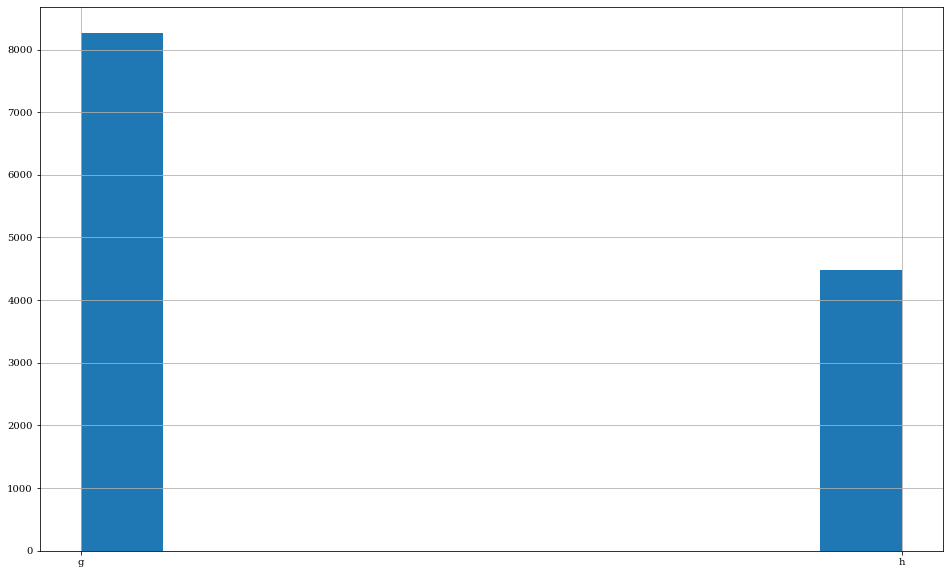

<IPython.core.display.Javascript object>

In [3]:
# Reading data
df = pd.read_csv("data/telescope_data.csv")
# Dropping useless column
df.drop("Unnamed: 0", axis=1, inplace=True)
# Setting feature matrix X and outcome y
X = df.drop("class", axis=1)
y = df["class"]

# Splitting
X_train, X_test, y_train, y_test = sklms.train_test_split(
    X, y, stratify=y, test_size=0.33
)

# Scaling feature matrix (All features are scalar).
scaler = sklpre.StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns
)
X_test = pd.DataFrame(scaler.transform(X_test.to_numpy()), columns=X_test.columns)

# One-hot encoding outcomes, keeping them as dataframes
encoder = sklpre.OneHotEncoder(categories="auto", sparse=False)
# Plotting histogram of outcomes
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
y_train.hist(ax=ax, density=False)

y_train = pd.DataFrame(
    encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
y_test = pd.DataFrame(
    encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)

plt.show()
# Deleting non-used objects to avoid bugs later and save memory
del X
del y
del df

In [8]:
batch_sizes = skopt.space.Integer(low=1, high=200, name="batch_size")
dropout_1 = skopt.space.Real(low=0, high=0.5, name="dropout_1")
dropout_2 = skopt.space.Real(low=0, high=0.5, name="dropout_2")
nodes_1 = skopt.space.Integer(low=1, high=20, name="nodes_1")
nodes_2 = skopt.space.Integer(low=1, high=10, name="nodes_2")
space = [batch_sizes, dropout_1, dropout_2, nodes_1, nodes_2]


@skopt.utils.use_named_args(dimensions=space)
def neural_network_fit(
    batch_size, dropout_1, dropout_2, nodes_1, nodes_2, return_epochs=False
):
    early_stop = callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=1, restore_best_weights=True
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(nodes_1, activation="relu"),
            tf.keras.layers.Dropout(dropout_1),
            tf.keras.layers.Dense(nodes_2, activation="relu"),
            tf.keras.layers.Dropout(dropout_2),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="categorical_crossentropy",
    )

    model.fit(
        X_train_split,
        y_train_split,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        verbose=0,
        callbacks=[early_stop],
    )
    if return_epochs:
        print("jeff")
        return early_stop.stopped_epoch
    y_pred_validation_nn = model.predict_classes(X_validation).reshape(-1, 1)
    y_pred_validation_nn = np.append(
        y_pred_validation_nn == 0, y_pred_validation_nn == 1, axis=1
    ).astype(np.int)
    f1_score_weighted_validation = sklme.f1_score(
        y_true=y_validation, y_pred=y_pred_validation_nn, average="weighted"
    )

    return 1 - f1_score_weighted_validation


n_points = 10
optimizer_nn = skopt.gp_minimize(
    func=neural_network_fit,
    dimensions=space,
    n_jobs=-1,
    verbose=True,
    n_calls=n_points,
    n_random_starts=n_points,
)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,0.715949,-0.203190,0.283081,0.057046,0.265318,0.532114,0.397636,0.366872,-0.936803,2.200330
1,1.270275,3.799923,1.685473,-0.995620,-0.913203,-2.964454,1.508882,-3.543520,1.850820,3.150451
2,0.609944,1.085861,2.294066,-1.472814,-1.434176,0.269225,1.171554,-2.745707,-0.837375,-0.234822
3,0.204808,-0.443810,-0.874983,0.376995,0.425408,-1.409361,0.723692,-0.336657,-1.009630,0.792204
4,-0.597790,-0.288302,-0.565813,-0.398855,-0.550512,0.259670,-0.466805,0.426969,0.623391,0.136308
...,...,...,...,...,...,...,...,...,...,...
12738,-0.861064,-0.326860,-0.257490,0.145496,0.884877,-0.029085,-0.541155,-0.275811,0.167368,0.464002
12739,0.094879,-0.121821,0.367208,-1.002172,-1.036210,0.258499,0.657620,0.666286,-0.585802,0.714654
12740,-0.566153,-0.227312,0.034940,-0.212127,-0.199578,0.488709,-0.017101,-0.446732,-0.812221,0.228368
12741,-0.504390,-0.319210,-0.309407,-0.177729,-0.224903,0.627921,0.326203,0.495212,-0.933336,-0.025711


<IPython.core.display.Javascript object>

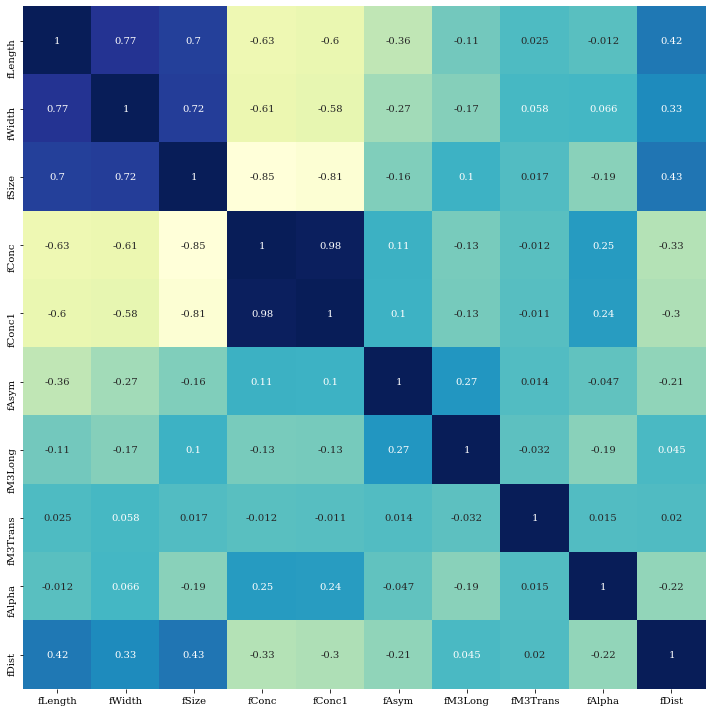

<IPython.core.display.Javascript object>

In [7]:
pca = sklde.PCA(n_components="mle")
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
sns.heatmap(
    X_train_pca.corr(), cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False
)
ax.set_ylim([9, 0])
ax.set_xlim([0, 9])
fig.tight_layout()
plt.show()

# kNN

In [8]:
knn_base = sklne.KNeighborsClassifier()

hyperparams_knn = {"n_neighbors": np.arange(1, 50)}
# As we saw in the earlier plot, we have an imbalanced dataset. Therefore we use the F1 score instead of accuracy
grid_search_knn = sklms.GridSearchCV(
    knn_base,
    hyperparams_knn,
    scoring="f1_weighted",
    cv=5,
    iid=False,
    n_jobs=-1,
    verbose=0,
).fit(X_train, y_train)

<IPython.core.display.Javascript object>

k-NN:
Train weighted f1 score: 0.88
Test weighted f1 score: 0.83
Best k = 5


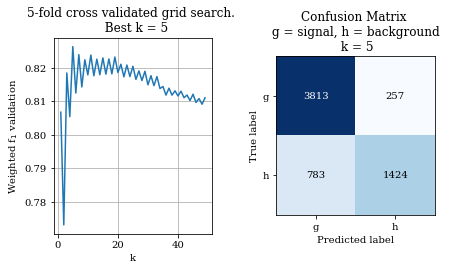

<IPython.core.display.Javascript object>

In [9]:
best_batch_nn = optimizer_nn["x"][0]
best_dropout_1 = optimizer_nn["x"][1]
best_dropout_2 = optimizer_nn["x"][2]
best_nodes_1 = optimizer_nn["x"][3]
best_nodes_2 = optimizer_nn["x"][4]
print(
    type(best_batch_nn),
    type(best_dropout_1),
    best_dropout_2,
    type(best_nodes_1),
    best_nodes_2,
)
best_epochs = neural_network_fit.__wrapped__(
    best_batch_nn, best_dropout_1, best_dropout_2, best_nodes_1, best_nodes_2, True,
)
print(best_epochs)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)

model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    epochs=best_epochs,
    batch_size=best_batch_nn,
    verbose=1,
)
model.save_weights("models/best_nn_not_pca")
np.save("models/best_hyperparams_nn.npy", optimizer_nn["x"])

# Tensorflow neural network
## Setting hyperparameters based on validation f1

In [4]:
X_train_split, X_validation, y_train_split, y_validation = sklms.train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train
)
X_train_split = X_train_split.to_numpy()
X_validation = X_validation.to_numpy()

y_train_split = y_train_split.to_numpy()

y_validation = y_validation.to_numpy()

<IPython.core.display.Javascript object>

In [28]:
batch_sizes = skopt.space.Integer(low=1, high=200, name="batch_size")
dropout_1 = skopt.space.Real(low=0, high=0.5, name="dropout_1")
dropout_2 = skopt.space.Real(low=0, high=0.5, name="dropout_2")
nodes_1 = skopt.space.Integer(low=1, high=20, name="nodes_1")
nodes_2 = skopt.space.Integer(low=1, high=10, name="nodes_2")
space = [batch_sizes, dropout_1, dropout_2, nodes_1, nodes_2]


@skopt.utils.use_named_args(dimensions=space)
def neural_network_fit(
    batch_size, dropout_1, dropout_2, nodes_1, nodes_2, return_epochs=False
):
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=1, restore_best_weights=True
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(nodes_1, activation="relu"),
            tf.keras.layers.Dropout(dropout_1),
            tf.keras.layers.Dense(nodes_2, activation="relu"),
            tf.keras.layers.Dropout(dropout_2),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="categorical_crossentropy",
    )

    model.fit(
        X_train_split,
        y_train_split,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        verbose=0,
        callbacks=[early_stop],
    )
    if return_epochs:
        print("jeff")
        return early_stop.stopped_epoch
    y_pred_validation_nn = model.predict_classes(X_validation).reshape(-1, 1)
    y_pred_validation_nn = np.append(
        y_pred_validation_nn == 0, y_pred_validation_nn == 1, axis=1
    ).astype(np.int)
    f1_score_weighted_validation = sklme.f1_score(
        y_true=y_validation, y_pred=y_pred_validation_nn, average="weighted"
    )

    return 1 - f1_score_weighted_validation


n_points = 10
optimizer_nn = skopt.gp_minimize(
    func=neural_network_fit,
    dimensions=space,
    n_jobs=-1,
    verbose=True,
    n_calls=n_points,
    n_random_starts=n_points,
)

Iteration No: 1 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.7794
Function value obtained: 0.1378
Current minimum: 0.1378
Iteration No: 2 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.5742
Function value obtained: 0.1525
Current minimum: 0.1378
Iteration No: 3 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.6561
Function value obtained: 0.1906
Current minimum: 0.1378
Iteration No: 4 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Iteration No: 4 ended. 

<IPython.core.display.Javascript object>

## Refitting on full training set

In [9]:
best_batch_nn = optimizer_nn["x"][0]
best_dropout_1 = optimizer_nn["x"][1]
best_dropout_2 = optimizer_nn["x"][2]
best_nodes_1 = optimizer_nn["x"][3]
best_nodes_2 = optimizer_nn["x"][4]
print(
    type(best_batch_nn),
    type(best_dropout_1),
    best_dropout_2,
    type(best_nodes_1),
    best_nodes_2,
)
best_epochs = neural_network_fit.__wrapped__(
    best_batch_nn, best_dropout_1, best_dropout_2, best_nodes_1, best_nodes_2, True,
)
print(best_epochs)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)

model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    epochs=best_epochs,
    batch_size=best_batch_nn,
    verbose=1,
)
model.save_weights("models/best_nn_not_pca")
np.save("models/best_hyperparams_nn.npy", optimizer_nn["x"])

<class 'numpy.int64'> <class 'numpy.float64'> 0.29362821151852664 <class 'numpy.int64'> 5
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
jeff
52
Train on 12743 samples
Epoch 1/52
12743/12743 [==============================] - 0s 27us/sample - loss: 0.7929
Epoch 2/52
12743/12743 [==============================] - 0s 6us/sample - loss: 0.6357
Epoch 3/52
12743/12743 [==============================] - 0s 7us/sample - loss: 0.5794
Epoch 4/52
12743/12743 [==============================] - 0s 7us/sample - loss: 0.5363
Epoch 5/52
12743/12743 [==============================] - 0s 6us/sample - loss: 0.5081
Epoch 6/52
12743/12743 [==============================] - 0s 7us/sample - loss: 0.4881
Epoch 7/52
12743/12743 [==============================] - 0s 7us/sample - loss: 0.4742
Epoch 8/52
12743/12743 [==============================] - 0s 6us/sample - loss: 0.4664
Epoch 9/52
12743/12743 [==============================] - 0s 8us/sample - loss: 0.4587
Epoch 10/52

<IPython.core.display.Javascript object>

Neural Network:
Train weighted f1 score: 0.86
Test weighted f1 score: 0.87
Best hyperparams: [1.50000000e+02 1.74726690e-02 2.93628212e-01 1.20000000e+01
 5.00000000e+00]


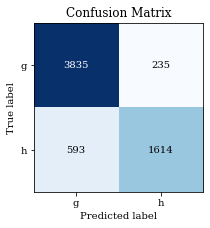

<IPython.core.display.Javascript object>

In [10]:
best_hyperparams = np.load("models/best_hyperparams_nn.npy")
best_batch_nn = best_hyperparams[0]
best_dropout_1 = best_hyperparams[1]
best_dropout_2 = best_hyperparams[2]
best_nodes_1 = best_hyperparams[3]
best_nodes_2 = best_hyperparams[4]

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)
model.load_weights("models/best_nn_not_pca")

y_pred_train_nn = model.predict_classes(X_train.to_numpy()).reshape(-1, 1)
y_pred_train_nn = np.append(y_pred_train_nn == 0, y_pred_train_nn == 1, axis=1).astype(
    np.int
)

y_pred_test_nn = model.predict_classes(X_test.to_numpy()).reshape(-1, 1)
y_pred_test_nn = np.append(y_pred_test_nn == 0, y_pred_test_nn == 1, axis=1).astype(
    np.int
)

f1_score_weighted_train = sklme.f1_score(
    y_true=y_train, y_pred=y_pred_train_nn, average="weighted"
)

f1_score_weighted_test = sklme.f1_score(
    y_true=y_test, y_pred=y_pred_test_nn, average="weighted"
)


print("Neural Network:")
print(f"Train weighted f1 score: {f1_score_weighted_train:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test:.2f}")
print(f"Best hyperparams: {best_hyperparams}")

fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    encoder.inverse_transform(y_pred_test_nn),
    ax=ax,
)
ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/nn_confusion_matrix.pdf", dpi=1000)
plt.show()

# XGBoost

In [73]:
y_train_boost = encoder.inverse_transform(y_train).ravel()
y_test_boost = encoder.inverse_transform(y_test).ravel()

y_train_split_boost = encoder.inverse_transform(y_train_split).ravel()
y_validation_boost = encoder.inverse_transform(y_validation).ravel()

validation_set_boost = [(X_validation, y_validation_boost)]

<IPython.core.display.Javascript object>

In [111]:
space_xg = [
    skopt.space.Real(low=1e-2, high=2e-1, prior="log-uniform", name="learning_rate"),
    skopt.space.Integer(low=1, high=10, name="max_tree_depth"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l1_alpha"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l2_lambda"),
    skopt.space.Integer(low=1, high=10, name="min_child_weight"),
]

<IPython.core.display.Javascript object>

In [112]:
@skopt.utils.use_named_args(dimensions=space_xg)
def xgboost_tune(
    learning_rate,
    max_tree_depth,
    l1_alpha,
    l2_lambda,
    min_child_weight,
    return_estimators=False,
):

    xgboost = xgb.XGBClassifier(
        objective="binary:logistic",
        n_jobs=-1,
        n_estimators=int(1e3),
        learning_rate=learning_rate,
        max_depth=max_tree_depth,
        reg_alpha=l1_alpha,
        reg_lambda=l2_lambda,
        min_child_weight=min_child_weight,
    ).fit(
        X=X_train_split,
        y=y_train_split_boost,
        eval_metric=["logloss"],
        eval_set=validation_set_boost,
        early_stopping_rounds=3,
        verbose=False,
    )

    y_pred_validation_boost = xgboost.predict(X_validation).reshape(-1, 1)
    f1_score_validation = sklme.f1_score(
        y_true=y_validation,
        y_pred=encoder.transform(y_pred_validation_boost),
        average="weighted",
    )

    if return_estimators:
        return xgboost.best_iteration

    return 1 - f1_score_validation

<IPython.core.display.Javascript object>

In [113]:
n_points_xg = 100
optimizer_xgboost = skopt.gp_minimize(
    func=xgboost_tune,
    dimensions=space_xg,
    n_jobs=1,
    verbose=True,
    n_calls=n_points_xg,
    n_random_starts=n_points_xg,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1903
Function value obtained: 0.1288
Current minimum: 0.1288
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8513
Function value obtained: 0.1226
Current minimum: 0.1226
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.5187
Function value obtained: 0.1242
Current minimum: 0.1226
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4117
Function value obtained: 0.1311
Current minimum: 0.1226
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3737
Function value obtained: 0.1242
Current minimum: 0.1226
Iteration No: 6 started. Evaluating

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 0.4587
Function value obtained: 0.1390
Current minimum: 0.1216
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 1.0842
Function value obtained: 0.1342
Current minimum: 0.1216
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 0.4331
Function value obtained: 0.1236
Current minimum: 0.1216
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 0.2552
Function value obtained: 0.1274
Current minimum: 0.1216
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.2062
Function value obtained: 0.1277
Current minimum: 0.1216
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. E

Iteration No: 86 ended. Evaluation done at random point.
Time taken: 1.7452
Function value obtained: 0.1300
Current minimum: 0.1216
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 2.7544
Function value obtained: 0.1327
Current minimum: 0.1216
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 1.7566
Function value obtained: 0.1345
Current minimum: 0.1216
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 0.8473
Function value obtained: 0.1366
Current minimum: 0.1216
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 90 ended. Evaluation done at random point.
Time taken: 0.3726
Function value obtained: 0.1523
Current minimum: 0.1216
Iteration No: 91 started. Evaluating function at random point.
Iteration No: 91 ended. E

<IPython.core.display.Javascript object>

In [114]:
(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
) = optimizer_xgboost["x"]

print(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
)

best_n_estimators = xgboost_tune.__wrapped__(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
    return_estimators=True,
)
print(best_n_estimators)

0.16060445075521934 6 0.07016708041675529 0.012040867819713788 8
56


<IPython.core.display.Javascript object>

In [129]:
xgboost_refit = xgb.XGBClassifier(
    objective="binary:logistic",
    n_jobs=-1,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_tree_depth,
    reg_alpha=best_l1_alpha,
    reg_lambda=best_l2_lambda,
    min_child_weight=best_min_child_weight,
    verbose=True,
).fit(X_train, y_train_boost)

xgboost_refit.save_model("models/best_xgboost.bin")
print(xgboost_refit)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.16060445075521934, max_delta_step=0, max_depth=6,
              min_child_weight=8, missing=None, n_estimators=56, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.07016708041675529, reg_lambda=0.012040867819713788,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbose=True, verbosity=1)


<IPython.core.display.Javascript object>

In [133]:
xg_test = xgb.XGBClassifier()
xg_test.load_model("models/best_xgboost.bin")
print(xg_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


<IPython.core.display.Javascript object>

XGBoost:
Train weighted f1 score: 0.91
Test weighted f1 score: 0.88


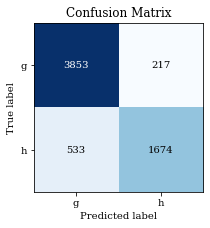

<IPython.core.display.Javascript object>

In [116]:
y_pred_train_boost = xgboost_refit.predict(X_train).reshape(-1, 1)
y_pred_test_boost = xgboost_refit.predict(X_test).reshape(-1, 1)

f1_score_weighted_train_boost = sklme.f1_score(
    y_true=y_train, y_pred=encoder.transform(y_pred_train_boost), average="weighted"
)

f1_score_weighted_test_boost = sklme.f1_score(
    y_true=y_test, y_pred=encoder.transform(y_pred_test_boost), average="weighted"
)

print("XGBoost:")
print(f"Train weighted f1 score: {f1_score_weighted_train_boost:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test_boost:.2f}")


fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()), y_pred_test_boost, ax=ax,
)

ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/xgboost_confusion_matrix.pdf", dpi=1000)
plt.show()

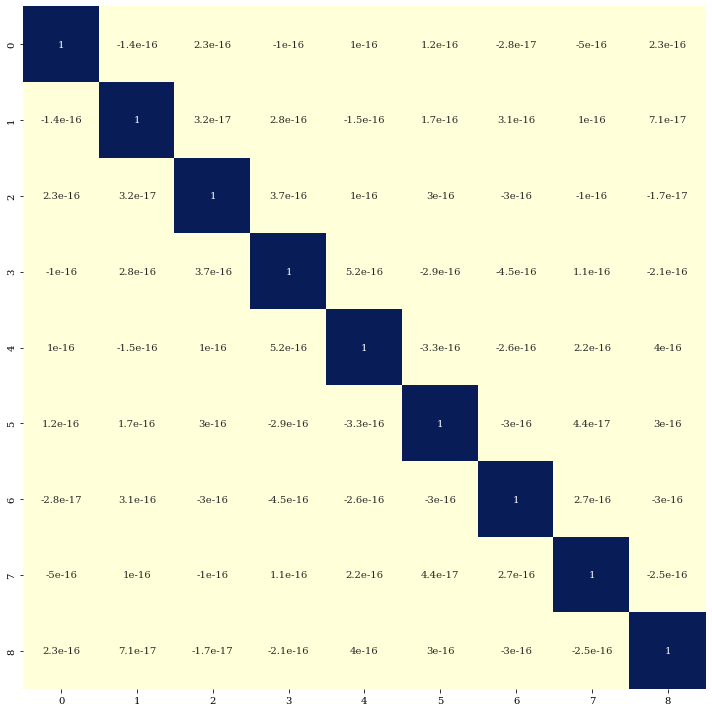

<IPython.core.display.Javascript object>

In [7]:
pca = sklde.PCA(n_components="mle")
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
sns.heatmap(
    X_train_pca.corr(), cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False
)
ax.set_ylim([9, 0])
ax.set_xlim([0, 9])
fig.tight_layout()
plt.show()